# Adaptive Computation for GP Kernel Discovery

This notebook explains how the Adaptive Computation (AC) allocation strategy works in our particle filter for Gaussian Process kernel discovery.

## Background

In a particle filter, we maintain a population of particles (hypotheses about the kernel structure) and periodically **rejuvenate** them using MCMC moves. A key question is: **how many MCMC moves should each particle get?**

The naive approach is **uniform allocation**: give every particle the same number of moves. But this is wasteful:
- Some particles are already well-converged (low acceptance rate)
- Some particles matter more for the final answer than others

**Adaptive Computation** allocates compute based on two factors:
1. **δ^S (Sensitivity)**: How much is this particle still "moving"? (via acceptance rate)
2. **δ^π (Decision Relevance)**: How much does this particle matter for our final answer? (via weight)

In [1]:
using Gen
using Plots
using Random
Random.seed!(42)

include("../src/inference/particle_filter.jl")

gp_particle_filter (generic function with 3 methods)

## The AC Formula

For each particle $i$, we compute a **task relevance** score:

$$\Delta_i = \log(\delta^\pi_i) + \log(\delta^S_i)$$

Where:
- $\delta^S_i$ = acceptance rate (high = still exploring, needs more compute)
- $\delta^\pi_i = 4 w_i (1 - w_i)$ where $w_i$ is the normalized weight

The **δ^π formula** is clever: it peaks at $w = 0.5$, meaning particles with "middling" weights are most decision-relevant. These are the competitive hypotheses that could swing the posterior either way.

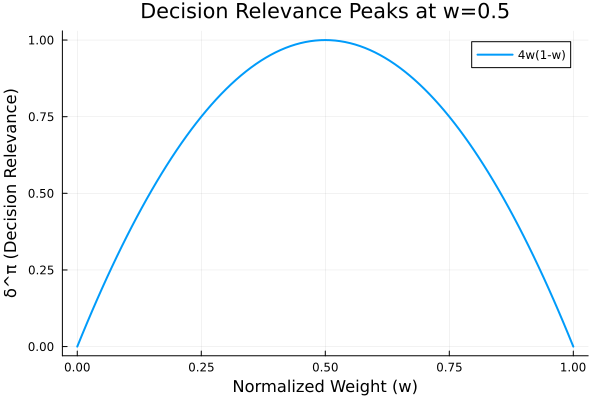

In [2]:
# Visualize the δ^π formula
w = 0:0.01:1
δπ = 4 .* w .* (1 .- w)

plot(w, δπ, 
    xlabel="Normalized Weight (w)", 
    ylabel="δ^π (Decision Relevance)",
    title="Decision Relevance Peaks at w=0.5",
    label="4w(1-w)",
    linewidth=2,
    legend=:topright)

## Load and Importance

From the task relevance scores, we compute:

**Load** (total compute budget for this round):
$$\text{load} = \min\left(m \cdot (x_0 + \text{logsumexp}(\Delta)), \alpha\right)$$

**Importance** (distribution across particles):
$$\text{importance}_i = \text{softmax}(\Delta / \tau)_i$$

**Final allocation**:
$$\text{allocations}_i = \text{round}(\text{importance}_i \cdot \text{load}) + j_{\min}$$

Where:
- $\tau$ = temperature (higher = more uniform)
- $x_0, m$ = load intercept and slope
- $\alpha$ = max budget cap
- $j_{\min}$ = minimum moves per particle

In [3]:
# Create an AC allocator
ac = AdaptiveComputation(
    τ = 1.0,    # importance temperature
    x0 = 5.0,   # load intercept
    m = 1.0,    # load slope
    α = 50,     # max budget cap
    jmin = 1    # minimum moves per particle
)

println("AC Parameters:")
println("  τ (temperature): $(ac.τ)")
println("  x0 (load intercept): $(ac.x0)")
println("  m (load slope): $(ac.m)")
println("  α (max budget): $(ac.α)")
println("  jmin (min moves): $(ac.jmin)")

AC Parameters:
  τ (temperature): 1.0
  x0 (load intercept): 5.0
  m (load slope): 1.0
  α (max budget): 50
  jmin (min moves): 1


## Simulating Acceptance History

Let's simulate different scenarios to see how AC allocates compute.

In [4]:
# Scenario: 4 particles with different acceptance rates and weights
n_particles = 4
traces = [nothing for _ in 1:n_particles]  # Dummy traces

# Simulate different acceptance histories
reset_round!(ac, n_particles)

# Particle 1: High acceptance (0.8) - still exploring
for _ in 1:8; record_move!(ac, 1, true); end
for _ in 1:2; record_move!(ac, 1, false); end

# Particle 2: Low acceptance (0.2) - converged
for _ in 1:2; record_move!(ac, 2, true); end
for _ in 1:8; record_move!(ac, 2, false); end

# Particle 3: Medium acceptance (0.5)
for _ in 1:5; record_move!(ac, 3, true); end
for _ in 1:5; record_move!(ac, 3, false); end

# Particle 4: No moves yet (defaults to 1.0)
# (no calls to record_move!)

println("Acceptance rates (δ^S):")
for i in 1:n_particles
    rate = get_acceptance_rate(ac, i)
    println("  Particle $i: $(round(rate, digits=2))")
end

Acceptance rates (δ^S):
  Particle 1: 0.8
  Particle 2: 0.2
  Particle 3: 0.5
  Particle 4: 1.0


In [5]:
# Now let's see how weights affect allocation
# Scenario A: All particles have similar weights
log_weights_uniform = [0.0, -0.1, -0.2, -0.3]

# Scenario B: One particle dominates
log_weights_dominant = [0.0, -5.0, -5.0, -5.0]

# Scenario C: Two competitive particles
log_weights_competitive = [-0.5, -0.5, -5.0, -5.0]

budget = 40

println("\n=== Scenario A: Similar Weights ===")
allocs_a = compute_allocations(ac, traces, log_weights_uniform, budget; verbose=true)

println("\n=== Scenario B: One Dominant Particle ===")
allocs_b = compute_allocations(ac, traces, log_weights_dominant, budget; verbose=true)

println("\n=== Scenario C: Two Competitive Particles ===")
allocs_c = compute_allocations(ac, traces, log_weights_competitive, budget; verbose=true)


=== Scenario A: Similar Weights ===
δ^S (acceptance): [0.8, 0.2, 0.5, 1.0]
Load: 5.6, Importance: [0.36, 0.08, 0.2, 0.36]
Allocations: [3, 1, 2, 3] (sum=9)

=== Scenario B: One Dominant Particle ===
δ^S (acceptance): [0.8, 0.2, 0.5, 1.0]
Load: 2.8, Importance: [0.58, 0.05, 0.12, 0.25]
Allocations: [3, 1, 1, 2] (sum=7)

=== Scenario C: Two Competitive Particles ===
δ^S (acceptance): [0.8, 0.2, 0.5, 1.0]
Load: 5.0, Importance: [0.77, 0.19, 0.01, 0.02]
Allocations: [5, 2, 1, 1] (sum=9)


4-element Vector{Int64}:
 5
 2
 1
 1

┌ Warning: Keyword argument bar_position not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, 

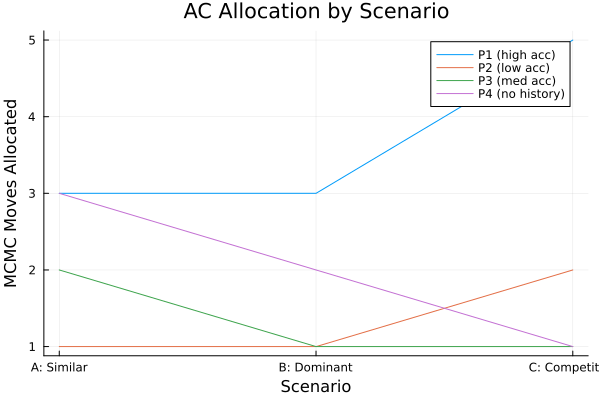

In [11]:
# Visualize the allocations
scenarios = ["A: Similar", "B: Dominant", "C: Competitive"]
all_allocs = hcat(allocs_a, allocs_b, allocs_c)

plot(all_allocs', 
    bar_position=:dodge,
    xlabel="Scenario",
    ylabel="MCMC Moves Allocated",
    title="AC Allocation by Scenario",
    xticks=(1:3, scenarios),
    label=["P1 (high acc)" "P2 (low acc)" "P3 (med acc)" "P4 (no history)"],
    legend=:topright)

## Comparison: Uniform vs Adaptive

Let's compare uniform allocation with adaptive computation on actual inference.

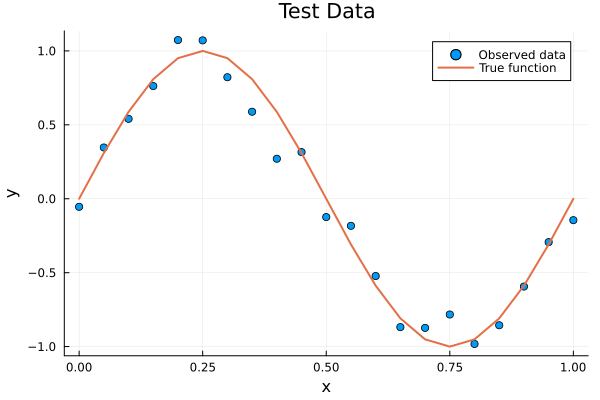

In [7]:
# Generate test data: a periodic signal
xs = collect(0.0:0.05:1.0)
true_ys = sin.(2π .* xs)
ys = true_ys .+ 0.15 .* randn(length(xs))

scatter(xs, ys, label="Observed data", xlabel="x", ylabel="y", title="Test Data")
plot!(xs, true_ys, label="True function", linewidth=2)

In [8]:
# Run with Uniform Allocation
println("Running with UniformAllocation...")
uniform_traces = gp_particle_filter(
    xs, ys,
    10,  # num_particles
    5,   # num_rounds
    10,  # num_mcmc_moves (ignored)
    5,   # num_samples
    UniformAllocation(),
    50;  # budget
    verbose=false
)

println("Kernels found:")
for (i, tr) in enumerate(uniform_traces)
    println("  Sample $i: $(get_retval(tr))")
end

Running with UniformAllocation...
Kernels found:
  Sample 1: SquaredExponential(0.09808100674922304)
  Sample 2: SquaredExponential(0.1660813561263642)
  Sample 3: SquaredExponential(0.16460633276954262)
  Sample 4: SquaredExponential(0.5080940890152849)
  Sample 5: SquaredExponential(0.11851329463306304)


In [9]:
# Run with Adaptive Computation
println("Running with AdaptiveComputation...")
ac_alloc = AdaptiveComputation(τ=1.0, x0=5.0, m=1.0, α=50, jmin=1)

ac_traces = gp_particle_filter(
    xs, ys,
    10,  # num_particles
    5,   # num_rounds
    10,  # num_mcmc_moves (ignored)
    5,   # num_samples
    ac_alloc,
    50;  # budget
    verbose=true
)

println("\nKernels found:")
for (i, tr) in enumerate(ac_traces)
    println("  Sample $i: $(get_retval(tr))")
end

Running with AdaptiveComputation...
δ^S (acceptance): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Load: 6.3, Importance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Allocations: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2] (sum=20)
δ^S (acceptance): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Load: 6.3, Importance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Allocations: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2] (sum=20)
δ^S (acceptance): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Load: 6.3, Importance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Allocations: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2] (sum=20)
δ^S (acceptance): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Load: 6.3, Importance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Allocations: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2] (sum=20)
δ^S (acceptance): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Load: 6.3, Importance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Allocations: [2, 2, 2, 2, 2, 2, 2, 2,

## Key Insights

### Why δ^S = acceptance_rate (not 1 - acceptance_rate)?

- **High acceptance** → proposals keep getting accepted → particle is still exploring → NOT converged → needs MORE compute
- **Low acceptance** → stuck at a mode, proposals rejected → converged → needs LESS compute

### Why δ^π = 4w(1-w)?

This formula peaks at w=0.5, meaning:
- Particles with very high weight (w≈1) are already "winners" - less compute needed
- Particles with very low weight (w≈0) are likely to be resampled away - less compute needed  
- Particles with middling weights (w≈0.5) are the competitive ones that could swing the posterior

### Why reset after resampling?

After resampling, particle indices get scrambled:
```
Before: [particle_A, particle_B, particle_C, particle_D]
After:  [particle_A, particle_A, particle_C, particle_C]  # B,D killed
```

The acceptance history for index 2 now belongs to dead particle B, but traces[2] is a copy of A. We must reset to avoid using stale/invalid history.

## Parameter Tuning Guide

| Parameter | Effect | Typical Range |
|-----------|--------|---------------|
| τ | Higher = more uniform allocation | 0.5 - 2.0 |
| x0 | Base load level | 3.0 - 10.0 |
| m | How much relevance affects load | 0.5 - 2.0 |
| α | Maximum total moves per round | 20 - 100 |
| jmin | Minimum moves per particle | 1 - 5 |

In [10]:
# Explore effect of temperature τ
log_weights = [-0.5, -0.5, -2.0, -3.0]
budget = 40

τ_values = [0.5, 1.0, 2.0, 5.0]
all_allocs_τ = []

for τ in τ_values
    ac_test = AdaptiveComputation(τ=τ, x0=5.0, m=1.0, α=50, jmin=1)
    reset_round!(ac_test, 4)
    # Same acceptance history as before
    for _ in 1:8; record_move!(ac_test, 1, true); end
    for _ in 1:2; record_move!(ac_test, 1, false); end
    for _ in 1:2; record_move!(ac_test, 2, true); end
    for _ in 1:8; record_move!(ac_test, 2, false); end
    for _ in 1:5; record_move!(ac_test, 3, true); end
    for _ in 1:5; record_move!(ac_test, 3, false); end
    
    allocs = compute_allocations(ac_test, traces, log_weights, budget)
    push!(all_allocs_τ, allocs)
end

groupedbar(hcat(all_allocs_τ...)', 
    bar_position=:dodge,
    xlabel="Temperature τ",
    ylabel="MCMC Moves",
    title="Effect of Temperature on Allocation",
    xticks=(1:4, string.(τ_values)),
    label=["P1" "P2" "P3" "P4"],
    legend=:topright)

LoadError: UndefVarError: `groupedbar` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Summary

Adaptive Computation intelligently allocates MCMC rejuvenation moves by considering:

1. **Which particles are still exploring** (high acceptance rate = needs more compute)
2. **Which particles matter for the final answer** (middling weights = decision-relevant)

This is more efficient than uniform allocation, especially when:
- Some particles converge faster than others
- The posterior is multimodal with competitive hypotheses
- Compute budget is limited